In [1]:
# Exploratory Data Analysis for Wind, Solar, and Load Time Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
import chardet

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read(10000)
    result = chardet.detect(raw_data)
    return result['encoding']

sr_encoding = detect_encoding('data/SRTable.csv')
#gen_encoding= detect_encoding('data/gen_df.csv')


gen_df = pd.read_csv('data/GenTable.csv',header=[1,2],index_col=0, date_format="%m/%d/%Y %I:%M:%S\u202f%p") # generation data
gen_df.columns=['_'.join([i for i in col]) for col in gen_df.columns]
gen_df.index.name='Date'

#gen_df.rename(columns={gen_df.columns[0]:'Date'}, inplace=True)
sr_df = pd.read_csv('data/SRTable.csv',index_col=0) # Load data 

cleaned = (
    sr_df.index
      .astype(str)
      .str.replace(r'[\u202f\?]', ' ', regex=True)
)
sr_df.index = pd.to_datetime(
    cleaned,
    format="%m/%d/%Y %I:%M:%S %p"
)
sr_df.index.name='Date'



## Dataset Overview
- Time period: Jan 1st, 2015 to  May 31st, 2025
- Data points: 3,804 days
- Core Metrics Analyzed:
  - Wind (Wind_Total Generation)
  - Solar (Solar_Total Generation)
  Load (System Load)

In [3]:
def clean_numeric_columns(df):
    for col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '').str.replace('%', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


generation_df = clean_numeric_columns(gen_df)
load_df = clean_numeric_columns(sr_df)


In [4]:
# Merge generation and load data for joint analysis
combined_df = generation_df.join(load_df, how='inner')

In [5]:
# Extract only relevant columns for analysis: Wind, Solar, Load. For a more focused analysis
eda_df = combined_df[[
    'Wind_Total Generation', 'Solar_Total Generation', 'System Load'
]].copy()


In [6]:
#eda_df.to_csv("data/renewable_data.csv")

In [67]:
print("--- info---")
eda_df.info()
print("")
print("---missing_values---")
print(eda_df.isna().sum())
print("")
print("---Basic statistics---")
eda_df.describe()


--- info---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3804 entries, 2015-01-01 to 2025-05-31
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wind_Total Generation   3804 non-null   int64  
 1   Solar_Total Generation  2735 non-null   float64
 2   System Load             3804 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 118.9 KB

---missing_values---
Wind_Total Generation        0
Solar_Total Generation    1069
System Load                  0
dtype: int64

---Basic statistics---


,Wind_Total Generation,Solar_Total Generation,System Load
count,3804.000000,2735.000000,3804.000000
mean,766.393796,126.261426,7046.544690
std,617.373689,171.735515,454.112798
min,1.000000,0.000000,5789.000000
25%,300.750000,4.000000,6715.000000
50%,613.000000,40.000000,7011.000000
75%,1044.000000,189.500000,7348.000000
max,3742.000000,834.000000,8601.000000


### Note
From the missing value information, we observe that 1069 null values are present for `Solar_Total generation` which is about 28% of the data. After further study, it was discovered that Alberta's first utility sclae, grid-connected solar facility began commercial operation in 2013 with Whitla Solar project. From this time up till 2018, it is possible AESO recorded solar generation under "other fuel generation" as the solar generation was too small to appear as their own line item.

<Axes: xlabel='Date'>

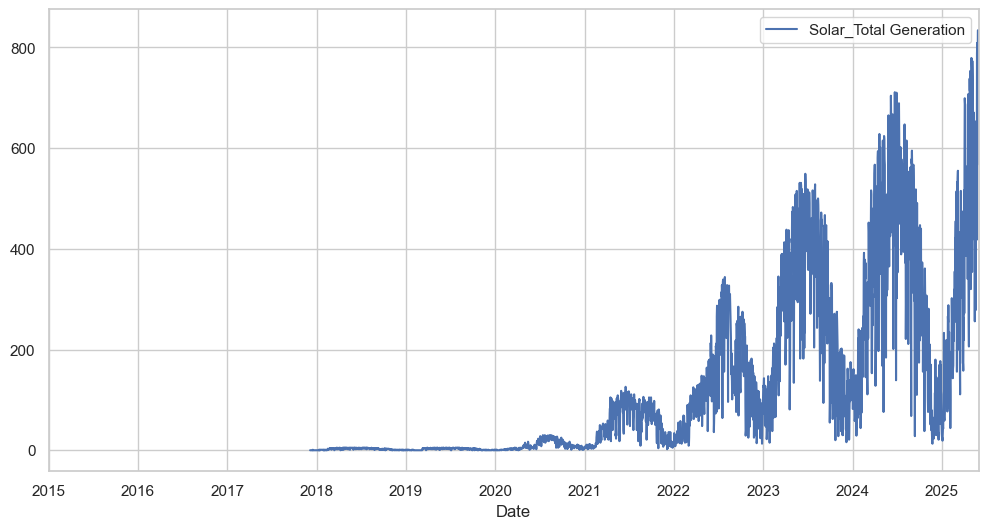

In [68]:
eda_df[['Solar_Total Generation']].plot()

In [98]:
eda_df=eda_df[eda_df.index >= '2018'].copy() #2018-2025 data

### Visualizing Trends

In [95]:
# Set style for plots
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Create monthly averages for trend analysis
monthly_df = eda_df.resample('ME').mean()

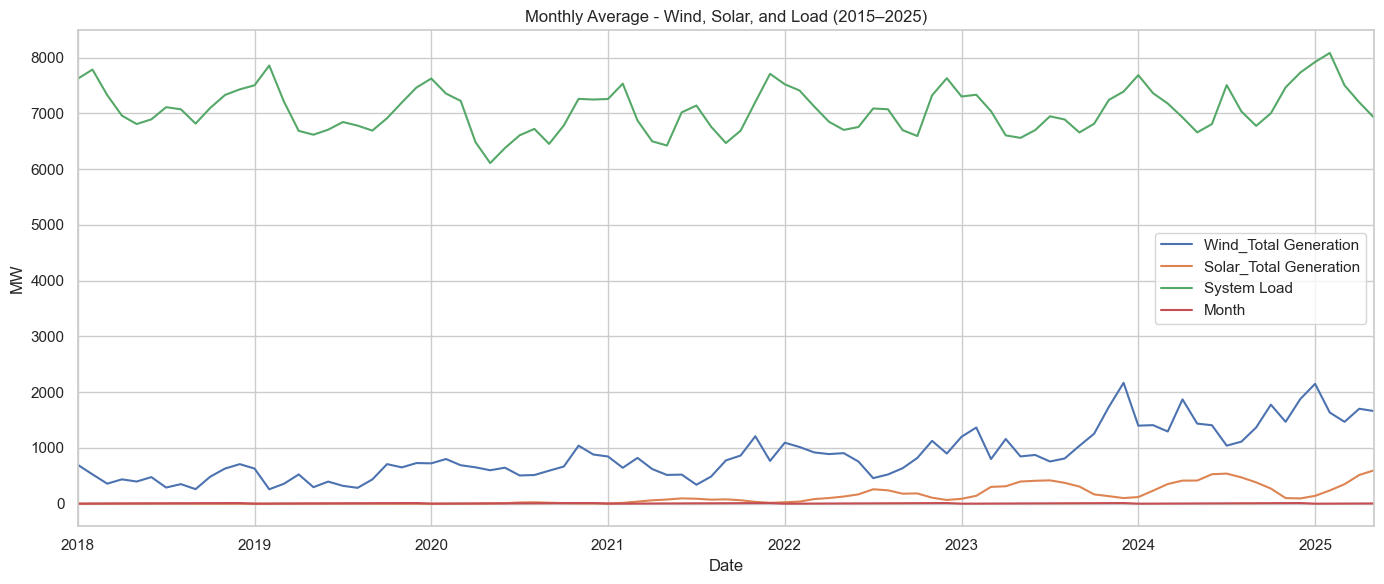

In [96]:
# Plot time series of monthly averages
fig, ax = plt.subplots()
monthly_df.plot(ax=ax)
ax.set_title("Monthly Average - Wind, Solar, and Load (2015–2025)")
ax.set_ylabel("MW")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

- Wind shows long-term variability with peaks and dips across years, but no strong yearly seasonality.
- Solar has a strong seasonal cycle: high in summer, low in winter, as expected.
- Load is relatively stable but has subtle seasonal peaks, likely in winter and summer (heating/cooling demand).
  

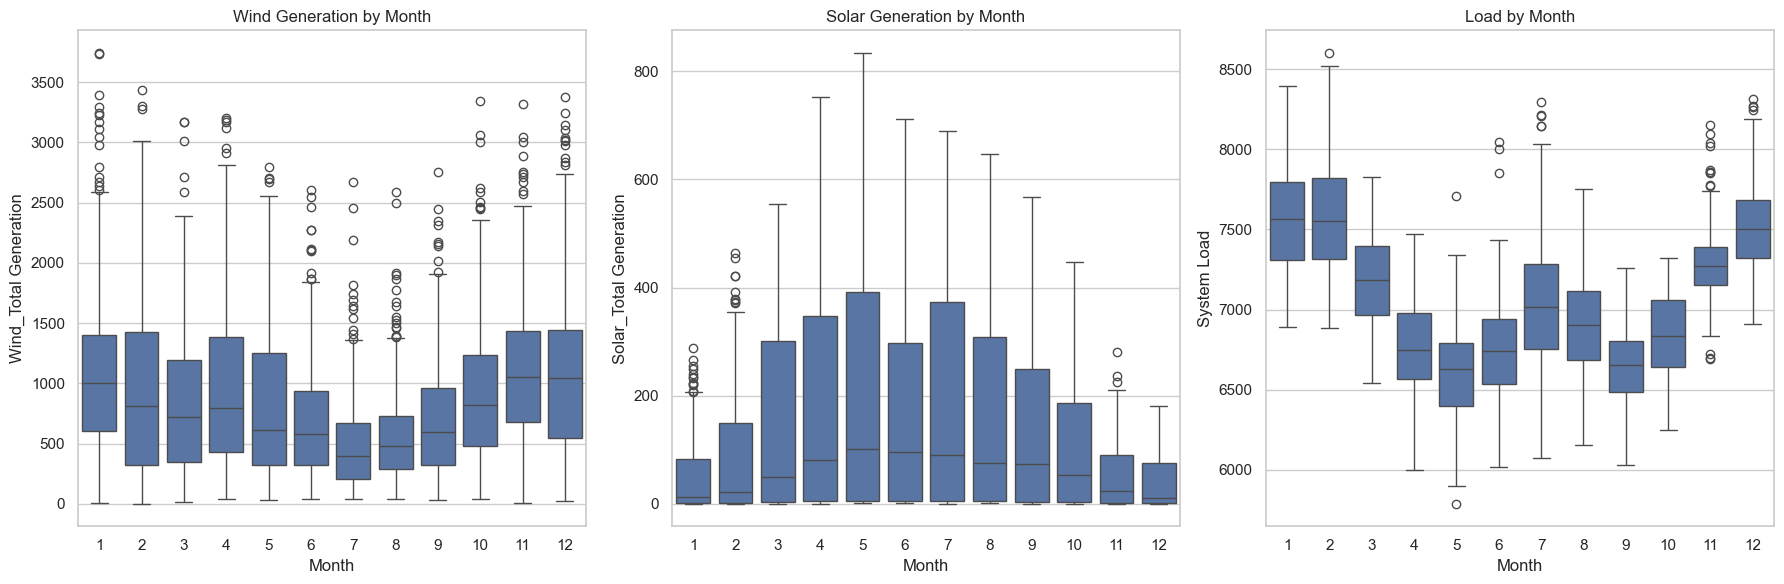

In [99]:
# Create boxplots for seasonality by month
eda_df['Month'] = eda_df.index.month

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
sns.boxplot(x='Month', y='Wind_Total Generation', data=eda_df, ax=ax[0])
ax[0].set_title('Wind Generation by Month')
sns.boxplot(x='Month', y='Solar_Total Generation', data=eda_df, ax=ax[1])
ax[1].set_title('Solar Generation by Month')
sns.boxplot(x='Month', y='System Load', data=eda_df, ax=ax[2])
ax[2].set_title('Load by Month')
plt.tight_layout()
plt.show()

- Wind: Fairly distributed year-round with no strong monthly pattern.
- Solar: Sharp increase from April to August; almost negligible in winter months.
- Load: Dual seasonal peaks (likely winter + summer), dip during spring/fall.

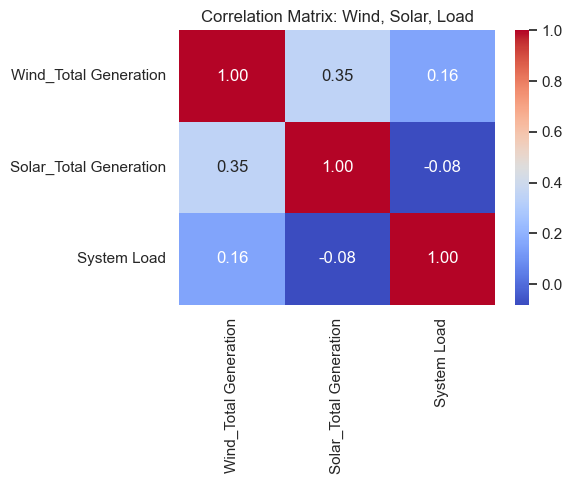

In [100]:
# Compute correlation matrix
corr_matrix = eda_df[['Wind_Total Generation', 'Solar_Total Generation', 'System Load']].corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Wind, Solar, Load")
plt.tight_layout()
plt.show()

In [7]:
# Define thresholds for extreme event detection
low_wind_thresh = eda_df['Wind_Total Generation'].quantile(0.10)
low_solar_thresh = eda_df['Solar_Total Generation'].quantile(0.10)
high_load_thresh = eda_df['System Load'].quantile(0.90)

# Filter extreme events: high load + low wind + low solar
extreme_events = eda_df[
    (eda_df['Wind_Total Generation'] <= low_wind_thresh) &
    (eda_df['Solar_Total Generation'] <= low_solar_thresh) &
    (eda_df['System Load'] >= high_load_thresh)
]

# Display summary
extreme_summary = {
    'total_extreme_events': len(extreme_events),
    'example_events': extreme_events.head()
}

extreme_summary

{'total_extreme_events': 23,
 'example_events':             Wind_Total Generation  Solar_Total Generation  System Load
 Date                                                                  
 2017-12-28                    155                     0.0         8073
 2017-12-29                     62                     0.0         8097
 2017-12-30                     71                     0.0         7994
 2018-01-11                     46                     0.0         8337
 2018-02-01                     63                     1.0         8075}

In [9]:
low_wind_thresh

155.0

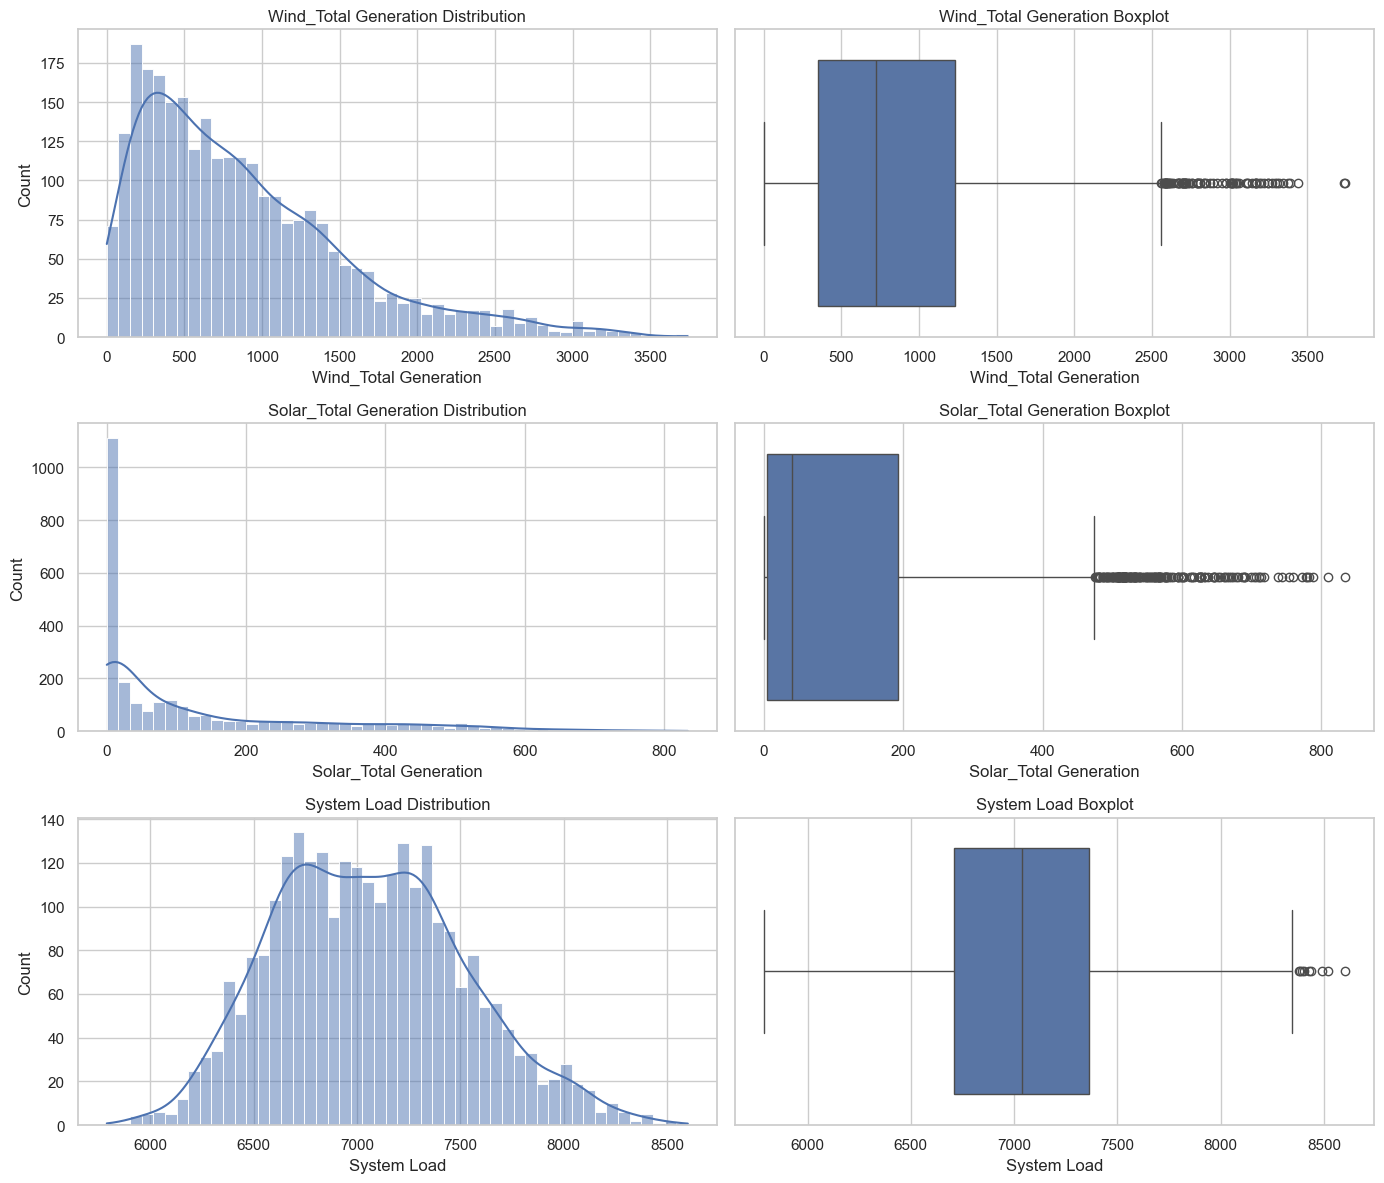

In [106]:
# Plot histograms and boxplots for distribution analysis
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

features = ['Wind_Total Generation', 'Solar_Total Generation', 'System Load']
for i, feature in enumerate(features):
    sns.histplot(eda_df[feature], bins=50, kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'{feature} Distribution')
    sns.boxplot(x=eda_df[feature], ax=axs[i, 1])
    axs[i, 1].set_title(f'{feature} Boxplot')

plt.tight_layout()
plt.show()



Wind
- Right-skewed distribution — many days with moderate generation, fewer with very high output.
- Outliers on the high end suggest periods of unusually strong wind generation.

Solar
- Heavily right-skewed, with a large spike at or near zero generation.
- Reflects winter months and missing data periods.
- Solar output varies widely, reinforcing the need for robust forecasting.

Load
- Normal-like distribution, relatively narrow spread.
- Fewer outliers — system load is generally stable and predictable, with seasonal variation.

In [10]:
eda_df

,Wind_Total Generation,Solar_Total Generation,System Load
Date,,,
2015-01-01,672,NaN,6942
2015-01-02,885,NaN,7535
2015-01-03,99,NaN,7601
2015-01-04,212,NaN,7694
2015-01-05,327,NaN,8000
...,...,...,...
2025-05-27,1356,782.0,7140
2025-05-28,347,834.0,7340
2025-05-29,2518,678.0,7706


In [11]:
combined_df

,Coal_Availability Factor,Coal_Availability Utilization,Coal_Capacity Factor,Coal_Maximum Capacity,Coal_Total Generation,Coal_System Capacity,Coal_System Available,Coal_System Generation,Cogeneration_Availability Factor,Cogeneration_Availability Utilization,...,Wind_System Available,Wind_System Generation,Calgary,Central,Edmonton,Losses,Northeast,Northwest,South,System Load
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,92.10,80.8,74.3,6271.0,4659.0,6271.0,5776.0,4664.0,61.98,41.3,...,132,672,1101,1336,1456,240,892,986,931,6942
2015-01-02,97.37,80.4,78.1,6271.0,4897.0,6271.0,6106.0,4904.0,64.52,40.1,...,132,885,1259,1440,1664,265,900,1023,985,7535
2015-01-03,95.43,85.5,81.4,6271.0,5107.0,6271.0,5985.0,5116.0,67.22,44.5,...,132,99,1253,1442,1668,262,915,1040,1021,7601
2015-01-04,97.68,85.7,83.5,6271.0,5239.0,6271.0,6126.0,5248.0,66.37,42.4,...,132,212,1267,1474,1711,289,884,1036,1033,7694
2015-01-05,98.82,82.8,81.7,6271.0,5123.0,6271.0,6197.0,5132.0,67.18,43.1,...,132,327,1387,1484,1846,295,927,1025,1035,8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.76,49.8,...,5311,1369,1217,1244,1588,326,1158,694,912,7140
2025-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.72,51.7,...,5326,341,1279,1247,1650,265,1236,708,955,7340
2025-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.90,47.1,...,5334,2520,1331,1261,1743,425,1265,696,985,7706


In [ ]:
combined_dfs=combined_df.copy()
combined_dfs["Date"]=combined_dfs.index

In [20]:
regions = ['Calgary', 'Central', 'Edmonton', 'Northeast', 'Northwest', 'South']
load_long = combined_dfs.melt(id_vars='Date', value_vars=regions, var_name='Region', value_name='Load (MW)')

In [21]:
load_long

,Date,Region,Load (MW)
0,2015-01-01,Calgary,1101
1,2015-01-02,Calgary,1259
2,2015-01-03,Calgary,1253
3,2015-01-04,Calgary,1267
4,2015-01-05,Calgary,1387
...,...,...,...
22819,2025-05-27,South,912
22820,2025-05-28,South,955
22821,2025-05-29,South,985
22822,2025-05-30,South,981


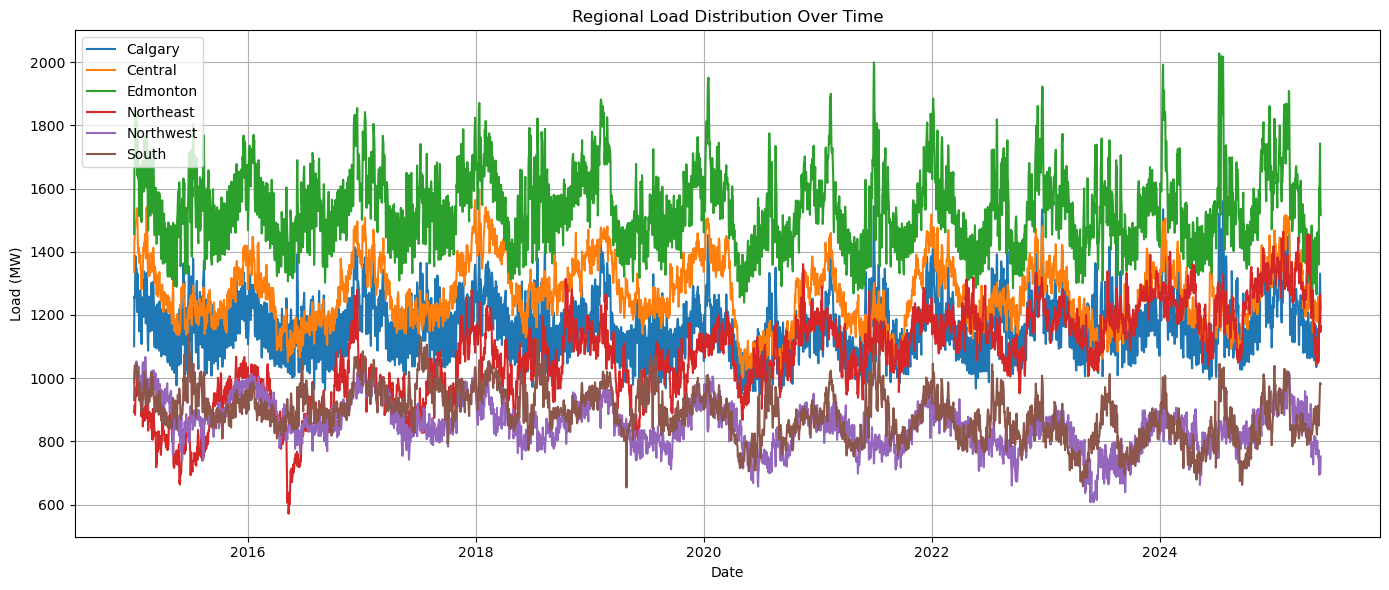

In [22]:
# Plot
plt.figure(figsize=(14, 6))
for region in regions:
    region_data = load_long[load_long["Region"] == region]
    plt.plot(region_data["Date"], region_data["Load (MW)"], label=region)

plt.title("Regional Load Distribution Over Time")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

 ## Data Preparation

In [2]:
data= pd.read_csv("data/renewable_data.csv")
data.Date= pd.to_datetime(data.Date)
train_df=data[(data.Date>="2018") & (data.Date<"2024")].reset_index(drop=True).copy()
test_df=data[data.Date>="2024"].reset_index(drop=True).copy()

In [3]:
#Adding features to help training
train_df['DayOfYear']=train_df.Date.dt.dayofyear
train_df['Weekday']=train_df.Date.dt.weekday
train_df['IsWeekend']=(train_df.Weekday >=5).astype("int8")
train_df['Month']=train_df.Date.dt.month

In [4]:
train_df

,Date,Wind_Total Generation,Solar_Total Generation,System Load,DayOfYear,Weekday,IsWeekend,Month
0,2018-01-01,608,0.0,7651,1,0,0,1
1,2018-01-02,686,0.0,7640,2,1,0,1
2,2018-01-03,603,0.0,7590,3,2,0,1
3,2018-01-04,548,0.0,7579,4,3,0,1
4,2018-01-05,944,0.0,7576,5,4,0,1
...,...,...,...,...,...,...,...,...
2186,2023-12-27,2374,122.0,7344,361,2,0,12
2187,2023-12-28,3245,151.0,7412,362,3,0,12
2188,2023-12-29,992,142.0,7136,363,4,0,12
2189,2023-12-30,2735,132.0,7208,364,5,1,12


## Detrending + residual modelling

In [5]:
from sklearn.linear_model import LinearRegression


In [6]:
# Add numeric time index for trend fitting
train_df['TimeIndex'] = np.arange(len(train_df))

In [7]:
# Function to detrend using linear regression
def detrend(series):
    X = train_df[['TimeIndex']]
    y = train_df[series]
    model = LinearRegression().fit(X, y)
    trend = model.predict(X)
    residual = y - trend
    return residual, trend, model

In [8]:
# Apply detrending to wind, solar, and load
residuals = {}
trends = {}
models = {}
for col in ['Wind_Total Generation', 'Solar_Total Generation', 'System Load']:
    res, trend, model = detrend(col)
    residuals[col] = res
    trends[col] = trend
    models[col] = model

In [9]:
# Add residuals to dataframe
train_df['Wind_Residual'] = residuals['Wind_Total Generation']
train_df['Solar_Residual'] = residuals['Solar_Total Generation']
train_df['Load_Residual'] = residuals['System Load']

train_df['Wind_Trend'] = trends['Wind_Total Generation']
train_df['Solar_Trend'] = trends['Solar_Total Generation']
train_df['Load_Trend'] = trends['System Load']

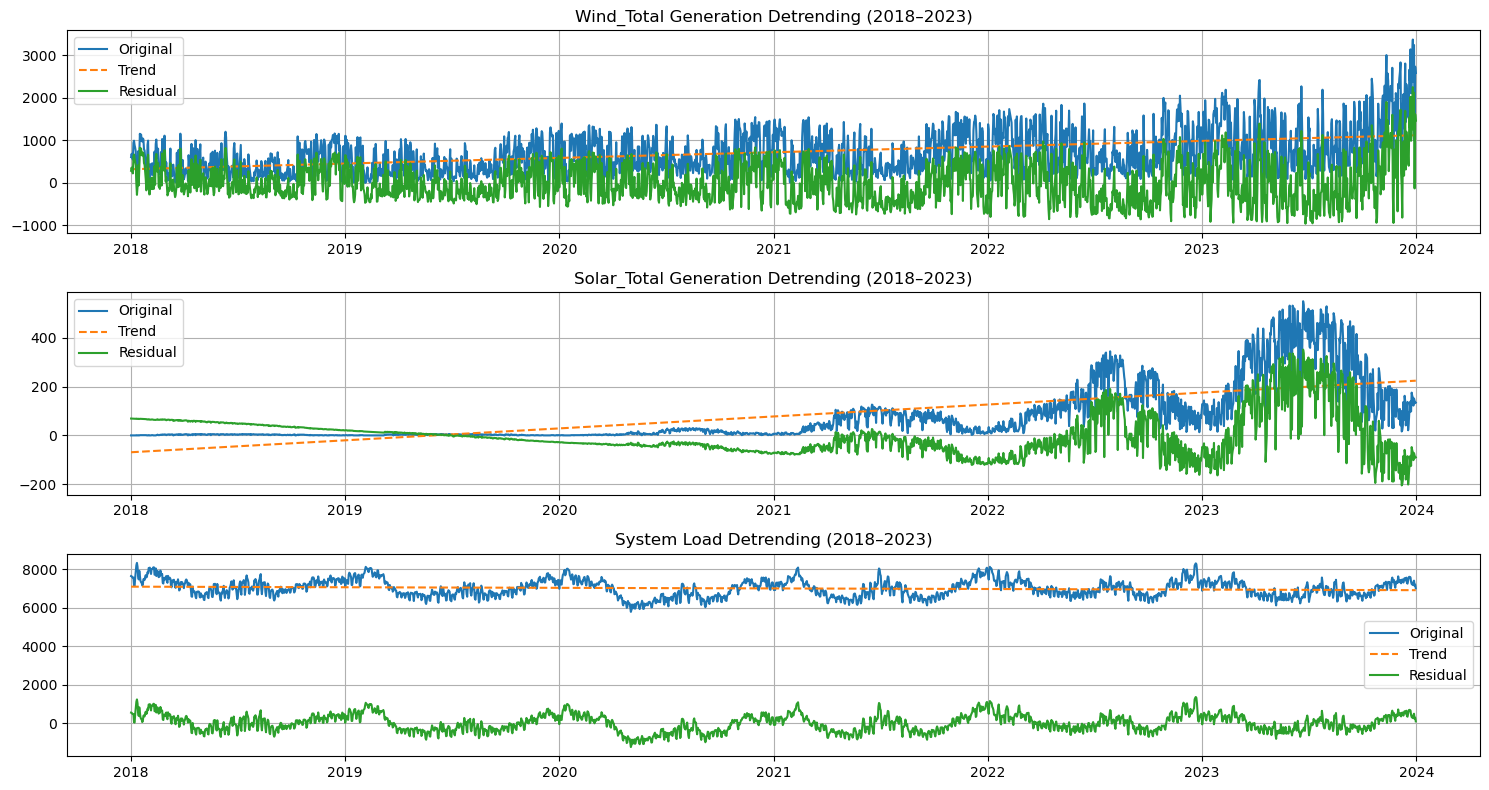

In [10]:
# Visualize: Wind Generation Trend and Residual
fig, axs= plt.subplots(3,1, figsize=(15,8))
generation=['Wind_Total Generation', 'Solar_Total Generation', 'System Load']
residual=['Wind_Residual','Solar_Residual','Load_Residual']
for ax, col, resid in zip(axs,generation,residual):
    ax.plot(train_df['Date'], train_df[col], label='Original')
    ax.plot(train_df['Date'], trends[col], label='Trend', linestyle='--')
    ax.plot(train_df['Date'], train_df[resid], label='Residual')
    ax.set_title(f"{col} Detrending (2018–2023)")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

In [11]:
train_df.to_csv("data/processed_data.csv")

## Feature Scaling

In [22]:
from sklearn.preprocessing import StandardScaler

residual_cols = ['Wind_Residual', 'Solar_Residual', 'Load_Residual']
calendar_cols = ['DayOfYear', 'Weekday', 'IsWeekend', 'Month']

scaler=StandardScaler()
train_df_scaled_residuals= pd.DataFrame(scaler.fit_transform(train_df[residual_cols]),columns=residual_cols,index=train_df.index)

train_df_scaled_residuals

## combining with calendar features
train_df_combined=  pd.concat([train_df_scaled_residuals, train_df[calendar_cols]], axis=1)

train_df_combined

,Wind_Residual,Solar_Residual,Load_Residual,DayOfYear,Weekday,IsWeekend,Month
0,0.616643,0.820240,1.255207,1,0,0,1
1,0.784245,0.818650,1.230343,2,1,0,1
2,0.604274,0.817060,1.116652,3,2,0,1
3,0.484750,0.815469,1.091787,4,3,0,1
4,1.338862,0.813879,1.085144,5,4,0,1
...,...,...,...,...,...,...,...
2186,2.707418,-1.204771,0.969685,361,2,0,12
2187,4.586977,-0.861309,1.124752,362,3,0,12
2188,-0.277669,-0.969984,0.496321,363,4,0,12
2189,3.484396,-1.090558,0.660498,364,5,1,12


In [23]:
## Save the scaler fitted to data for later use
import joblib
joblib.dump(scaler, 'scaler_model.joblib')


['scaler_model.joblib']

In [24]:
#Slice into sequences (e.g., 516-day windows)
sequence_length = 517
sequences = []

for i in range(len(train_df_combined) - sequence_length + 1):
    seq = train_df_combined.iloc[i:i + sequence_length].values
    sequences.append(seq)

sequences = np.array(sequences)
sequences.shape  # Confirm shape for TimeGAN training


(1675, 517, 7)

In [25]:
## Saving the final processed array 
np.save("data/timegan_517day_sequences.npy", sequences)

In [22]:
sequences[0].shape

(517, 7)

In [23]:
train_df_combined

,Wind_Residual,Solar_Residual,Load_Residual,DayOfYear,Weekday,IsWeekend,Month
0,0.616643,0.820240,1.255207,0.002732,0,0,0.083333
1,0.784245,0.818650,1.230343,0.005464,1,0,0.083333
2,0.604274,0.817060,1.116652,0.008197,2,0,0.083333
3,0.484750,0.815469,1.091787,0.010929,3,0,0.083333
4,1.338862,0.813879,1.085144,0.013661,4,0,0.083333
...,...,...,...,...,...,...,...
2186,2.707418,-1.204771,0.969685,0.986339,2,0,1.000000
2187,4.586977,-0.861309,1.124752,0.989071,3,0,1.000000
2188,-0.277669,-0.969984,0.496321,0.991803,4,0,1.000000
2189,3.484396,-1.090558,0.660498,0.994536,5,1,1.000000


## Forecast trend for 2024-2025



In [21]:
#Create 2024–2025 calendar features (516 days)
future_dates = pd.date_range(start="2024-01-01", periods=517, freq="D")
calendar_df = pd.DataFrame({"Date": future_dates})


In [23]:
# Add numeric time index for trend fitting
start=len(train_df)+1
stop=len(train_df)+len(test_df)+1
calendar_df['TimeIndex'] = np.arange(start,stop)

In [35]:
['Wind_Total Generation', 'Solar_Total Generation', 'System Load']
## Trends
calendar_df["Wind_Trend"] = models['Wind_Total Generation'].predict(calendar_df[['TimeIndex']])
calendar_df["Solar_Trend"] = models['Solar_Total Generation'].predict(calendar_df[['TimeIndex']])
calendar_df["Load_Trend"] = models['System Load'].predict(calendar_df[['TimeIndex']])

## residuals
calendar_df["Wind_Residual"]= test_df["Wind_Total Generation"]-calendar_df["Wind_Trend"]
calendar_df["Solar_Residual"]= test_df["Solar_Total Generation"]-calendar_df["Solar_Trend"]
calendar_df["Load_Residual"]= test_df["System Load"]-calendar_df["Load_Trend"]
# Preview trend forecast
calendar_df.head()

,Date,TimeIndex,Wind_Trend,Solar_Trend,Load_Trend,Wind_Residual,Solar_Residual,Load_Residual
0,2024-01-01,2192,1122.079018,224.057151,6917.754256,520.920982,-80.057151,6.245744
1,2024-01-02,2193,1122.443852,224.190816,6917.671164,-322.443852,-142.190816,482.328836
2,2024-01-03,2194,1122.808686,224.324481,6917.588072,-27.808686,-141.324481,701.411928
3,2024-01-04,2195,1123.173520,224.458147,6917.504979,620.826480,-73.458147,687.495021
4,2024-01-05,2196,1123.538354,224.591812,6917.421887,791.461646,-63.591812,638.578113


In [51]:
## Scale the residuals for the test set
residual_cols = ['Wind_Residual', 'Solar_Residual', 'Load_Residual']
calendar_df[residual_cols]=pd.DataFrame(scaler.fit_transform(calendar_df[residual_cols]),columns=residual_cols)

In [52]:
calendar_df

,Date,TimeIndex,Wind_Trend,Solar_Trend,Load_Trend,Wind_Residual,Solar_Residual,Load_Residual
0,2024-01-01,2192,1122.079018,224.057151,6917.754256,0.244976,-0.817988,-0.775126
1,2024-01-02,2193,1122.443852,224.190816,6917.671164,-0.770479,-1.133029,0.208602
2,2024-01-03,2194,1122.808686,224.324481,6917.588072,-0.415723,-1.128637,0.661293
3,2024-01-04,2195,1123.173520,224.458147,6917.504979,0.365268,-0.784528,0.632536
4,2024-01-05,2196,1123.538354,224.591812,6917.421887,0.570721,-0.734502,0.531459
...,...,...,...,...,...,...,...,...
512,2025-05-27,2704,1308.873975,292.493797,6875.211033,-0.325498,2.069915,-0.240899
513,2025-05-28,2705,1309.238809,292.627462,6875.127941,-1.540826,2.332897,0.172532
514,2025-05-29,2706,1309.603643,292.761127,6875.044848,1.072733,1.541240,0.928967
515,2025-05-30,2707,1309.968477,292.894793,6874.961756,0.124704,1.743378,-0.145335


In [55]:
test_df=calendar_df.merge(test_df, on="Date").copy()

In [57]:
test_df.to_csv("data/2024-2025.csv")